# 03 – Modeling
Train and persist the logistic-regression baseline plus a tuned XGBoost alternative: standardize the engineered features, run a group-aware hyperparameter search, fit both models on the SMOTE-rebalanced training fold, and store the artifacts for downstream evaluation.

Use this notebook whenever you want to refresh the trained models after updating the raw data or feature definitions.


In [1]:
import sys
from pathlib import Path

def _find_project_root(start: Path) -> Path:
    for candidate in (start, *start.parents):
        if (candidate / 'src').is_dir():
            return candidate
    raise RuntimeError("Could not locate project root containing a 'src' directory.")

PROJECT_ROOT = _find_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


## Prepare feature matrices
Load `features_full.csv`, derive both the base feature matrix and the advanced feature matrix, standardize them, and set up the group-aware train/test split (by `game_id`).


In [2]:
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from src.features.build_features import MODEL_FEATURE_COLUMNS, ADVANCED_FEATURE_COLUMNS
from src.utils.paths import PROCESSED_DATA_DIR, MODELS_DIR

MODELS_DIR.mkdir(parents=True, exist_ok=True)
features_path = PROCESSED_DATA_DIR / 'features_full.csv'
if not features_path.exists():
    raise FileNotFoundError('Run 02_feature_engineering.ipynb to create features_full.csv')

df = pd.read_csv(features_path)
game_ids = df['game_id']
base_feature_cols = [col for col in MODEL_FEATURE_COLUMNS if col in df.columns]
advanced_feature_cols = [col for col in ADVANCED_FEATURE_COLUMNS if col in df.columns]
X_base = df[base_feature_cols]
X_advanced = df[advanced_feature_cols]
y = df['home_win']
scaler_base = StandardScaler()
X_base_scaled = pd.DataFrame(scaler_base.fit_transform(X_base), columns=base_feature_cols)
scaler_advanced = StandardScaler()
X_advanced_scaled = pd.DataFrame(scaler_advanced.fit_transform(X_advanced), columns=advanced_feature_cols)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_base_scaled, y, groups=game_ids))
X_train = X_base_scaled.iloc[train_idx]
X_test = X_base_scaled.iloc[test_idx]
X_adv_train = X_advanced_scaled.iloc[train_idx]
X_adv_test = X_advanced_scaled.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = game_ids.iloc[train_idx]
X_base_scaled.head()


,home_point_diff,2FGA_h,2FGA_a,2FGM_h,2FGM_a,3FGA_h,3FGA_a,3FGM_h,3FGM_a,OREB_h,...,FTA_a,TOUT_h,TOUT_a,AST_h,AST_a,STL_h,STL_a,remaining_time_transformed,time_point_diff_interaction,home_prior
0,-0.204739,-1.577525,-1.574615,-1.518157,-1.516747,-1.451874,-1.443751,-1.292206,-1.267089,-1.255967,...,-1.13528,-1.017097,-1.063444,-1.456065,-1.439062,-1.206613,-1.196994,-0.070875,-0.019935,0.0
1,-0.204739,-1.577525,-1.574615,-1.518157,-1.516747,-1.451874,-1.443751,-1.292206,-1.267089,-1.255967,...,-1.13528,-1.017097,-1.063444,-1.456065,-1.439062,-1.206613,-1.196994,-0.070875,-0.019935,0.0
2,-0.204739,-1.577525,-1.574615,-1.518157,-1.516747,-1.451874,-1.443751,-1.292206,-1.267089,-1.255967,...,-1.13528,-1.017097,-1.063444,-1.456065,-1.439062,-1.206613,-1.196994,-0.070875,-0.019935,0.0
3,-0.204739,-1.577525,-1.574615,-1.518157,-1.516747,-1.451874,-1.443751,-1.292206,-1.267089,-1.255967,...,-1.13528,-1.017097,-1.063444,-1.456065,-1.439062,-1.206613,-1.196994,-0.070875,-0.019935,0.0
4,-0.204739,-1.577525,-1.574615,-1.518157,-1.516747,-1.451874,-1.443751,-1.292206,-1.267089,-1.255967,...,-1.13528,-1.017097,-1.063444,-1.456065,-1.439062,-1.206613,-1.196994,-0.070875,-0.019935,0.0


## Hyperparameter search helper
Utility function that evaluates a small parameter grid using group-aware splits (with SMOTE applied inside each fold) and returns the configuration with the lowest mean Brier score.


In [3]:
def tune_xgb(X_train, y_train, groups, param_grid, n_splits: int = 3):
    splitter = GroupShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    records: list[dict] = []
    best_params = None
    best_score = float('inf')
    for params in param_grid:
        fold_scores: list[float] = []
        for inner_train_idx, inner_val_idx in splitter.split(X_train, y_train, groups=groups):
            X_inner_train = X_train.iloc[inner_train_idx]
            y_inner_train = y_train.iloc[inner_train_idx]
            X_inner_val = X_train.iloc[inner_val_idx]
            y_inner_val = y_train.iloc[inner_val_idx]
            smote = SMOTE(random_state=42)
            X_inner_train_bal, y_inner_train_bal = smote.fit_resample(X_inner_train, y_inner_train)
            candidate = XGBClassifier(
                **params,
                random_state=42,
                n_jobs=-1,
                eval_metric='logloss',
            )
            candidate.fit(X_inner_train_bal, y_inner_train_bal)
            preds = candidate.predict_proba(X_inner_val)[:, 1]
            fold_scores.append(brier_score_loss(y_inner_val, preds))
        mean_score = float(np.mean(fold_scores))
        records.append({'params': params, 'mean_brier': mean_score})
        if mean_score < best_score:
            best_score = mean_score
            best_params = params
    results_df = pd.DataFrame(records).sort_values('mean_brier')
    return best_params, results_df


In [4]:
xgb_param_grid = [
    {
        'n_estimators': 400,
        'learning_rate': 0.05,
        'max_depth': 3,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_lambda': 1.0,
    },
    {
        'n_estimators': 600,
        'learning_rate': 0.03,
        'max_depth': 4,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'reg_lambda': 1.5,
    },
    {
        'n_estimators': 500,
        'learning_rate': 0.04,
        'max_depth': 5,
        'subsample': 0.85,
        'colsample_bytree': 0.8,
        'reg_lambda': 1.0,
    },
]


## Hyperparameter search (base features)
Evaluate the XGBoost grid using the base feature matrix.


In [5]:
best_xgb_params_base, cv_results_base = tune_xgb(X_train, y_train, groups_train, xgb_param_grid)
cv_results_base


,params,mean_brier
0,"{'n_estimators': 400, 'learning_rate': 0.05, '...",0.179587
1,"{'n_estimators': 600, 'learning_rate': 0.03, '...",0.180257
2,"{'n_estimators': 500, 'learning_rate': 0.04, '...",0.181283


## Hyperparameter search (advanced features)
Repeat the grid search using the advanced feature matrix derived from the base play-by-play stats.


In [6]:
best_xgb_params_advanced, cv_results_advanced = tune_xgb(X_adv_train, y_train, groups_train, xgb_param_grid)
cv_results_advanced


,params,mean_brier
0,"{'n_estimators': 400, 'learning_rate': 0.05, '...",0.201638
1,"{'n_estimators': 600, 'learning_rate': 0.03, '...",0.202939
2,"{'n_estimators': 500, 'learning_rate': 0.04, '...",0.205685


## Train and compare (base features)
Fit logistic regression and the tuned XGBoost model on the SMOTE-balanced training fold, then capture the hold-out metrics.


In [ ]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_bal, y_train_bal)
y_pred_log = log_reg.predict_proba(X_test)[:, 1]

xgb_base = XGBClassifier(
    **best_xgb_params_base,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
)
xgb_base.fit(X_train_bal, y_train_bal)
y_pred_xgb_base = xgb_base.predict_proba(X_test)[:, 1]

metrics_rows = {
    'logistic (base features)': {
        'Brier score': brier_score_loss(y_test, y_pred_log),
        'ROC AUC': roc_auc_score(y_test, y_pred_log),
    },
    'xgboost (base features)': {
        'Brier score': brier_score_loss(y_test, y_pred_xgb_base),
        'ROC AUC': roc_auc_score(y_test, y_pred_xgb_base),
    },
}
pd.DataFrame(metrics_rows).T


,Brier score,ROC AUC
logistic (base features),0.180876,0.799319
xgboost (base features),0.177164,0.802139


## Train XGBoost (advanced features)
Use the advanced feature matrix with the tuned hyperparameters to add a third model to the comparison table.


In [8]:
smote = SMOTE(random_state=42)
X_adv_train_bal, y_adv_train_bal = smote.fit_resample(X_adv_train, y_train)

xgb_advanced = XGBClassifier(
    **best_xgb_params_advanced,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
)
xgb_advanced.fit(X_adv_train_bal, y_adv_train_bal)
y_pred_xgb_advanced = xgb_advanced.predict_proba(X_adv_test)[:, 1]

metrics_rows['xgboost (advanced features)'] = {
    'Brier score': brier_score_loss(y_test, y_pred_xgb_advanced),
    'ROC AUC': roc_auc_score(y_test, y_pred_xgb_advanced),
}
metrics_df = pd.DataFrame(metrics_rows).T
metrics_df


,Brier score,ROC AUC
logistic (base features),0.180876,0.799319
xgboost (base features),0.177164,0.802139
xgboost (advanced features),0.193779,0.768012


## Coefficient spotlight
Visualize the largest logistic-regression coefficients to keep intuition about which engineered stats drive predictions.


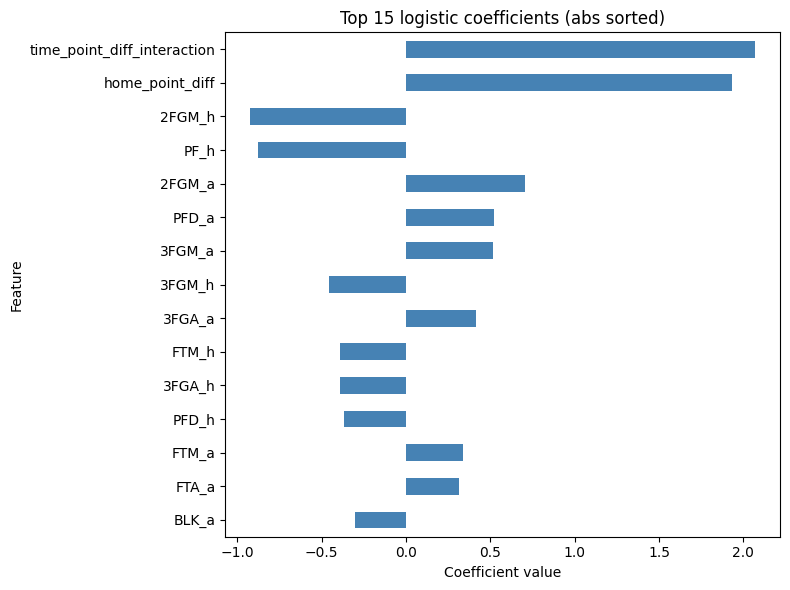

In [11]:
coefficients = pd.Series(log_reg.coef_[0], index=base_feature_cols)
coefficients_sorted = coefficients.reindex(coefficients.abs().sort_values(ascending=False).index)
top_n = 15
fig, ax = plt.subplots(figsize=(8, 6))
coefficients_sorted.head(top_n)[::-1].plot(kind='barh', ax=ax, color='steelblue')
ax.set_title(f'Top {top_n} logistic coefficients (abs sorted)')
ax.set_xlabel('Coefficient value')
ax.set_ylabel('Feature')
fig.tight_layout()


## Persist trained models
Save both scalers, all fitted models, and metadata so evaluation notebooks can reload everything without rerunning the training loops.


In [12]:
scaler_base_path = MODELS_DIR / 'feature_scaler_base.joblib'
scaler_adv_path = MODELS_DIR / 'feature_scaler_advanced.joblib'
logistic_path = MODELS_DIR / 'logistic_model.joblib'
xgb_base_path = MODELS_DIR / 'xgboost_base_model.joblib'
xgb_adv_path = MODELS_DIR / 'xgboost_advanced_model.joblib'
metadata_path = MODELS_DIR / 'training_metadata.json'
cv_base_path = MODELS_DIR / 'xgb_cv_results_base.csv'
cv_adv_path = MODELS_DIR / 'xgb_cv_results_advanced.csv'

joblib.dump(scaler_base, scaler_base_path)
joblib.dump(scaler_advanced, scaler_adv_path)
joblib.dump(log_reg, logistic_path)
joblib.dump(xgb_base, xgb_base_path)
joblib.dump(xgb_advanced, xgb_adv_path)
cv_results_base.to_csv(cv_base_path, index=False)
cv_results_advanced.to_csv(cv_adv_path, index=False)
metadata = {
    'split': {'test_size': 0.2, 'random_state': 42},
    'base': {
        'feature_columns': base_feature_cols,
        'scaler': scaler_base_path.name,
        'logistic_model': logistic_path.name,
        'xgb_model': xgb_base_path.name,
        'best_xgb_params': best_xgb_params_base,
        'xgb_cv_results': cv_base_path.name,
    },
    'advanced': {
        'feature_columns': advanced_feature_cols,
        'scaler': scaler_adv_path.name,
        'xgb_model': xgb_adv_path.name,
        'best_xgb_params': best_xgb_params_advanced,
        'xgb_cv_results': cv_adv_path.name,
    },
}
with open(metadata_path, 'w', encoding='utf-8') as fh:
    json.dump(metadata, fh, indent=2)



## Notes
- Uses the same recipe across reruns (scaling → group-aware split → SMOTE → logistic regression baseline) and adds both XGBoost baselines (raw features) plus the advanced feature variant for a nonlinear benchmark.
- Persists the scalers, models, CV results, and metadata under `models/` so evaluation notebooks do not retrain.
- Toggle `base_feature_cols`/`advanced_feature_cols` or SMOTE usage to run ablation studies before saving new artifacts.
